# Dataloading

In [60]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import numpy as np

# Load the connectome CSV file without the first column (which contains patient IDs)
connectome_df_no_labels = pd.read_csv(TRAIN_DIR + '/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv', index_col=0)

categorical_df = pd.read_excel("./data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
solutions_df = pd.read_excel("./data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# load categorical labels
with open("categorical_labels.json", "r") as file:
    categorical_labels = json.load(file)

# json cant store keys of type int, cast int keys back to int
categorical_labels = {category: {int(key): label for key, label in mapping.items()} for category, mapping in categorical_labels.items()}

# Preprocessing
## GNN Baseline

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [73]:
# get the number of patients and the length of the vector for each patient
num_patients = connectome_df_no_labels.shape[0]
vector_length = connectome_df_no_labels.shape[1]

# reconstruct the matrix size from the vector length
n = int((1 + math.sqrt(1 + 8 * vector_length)) / 2)  # should be 200

# initialize a 3d numpy array to store all matrices
connectome_array = np.zeros((num_patients, n, n))

# fill the array with each patient's full matrix
for patient_index in range(num_patients):
    patient_vector = connectome_df_no_labels.iloc[patient_index].values

    matrix = np.zeros((n, n))
    lower_indices = np.tril_indices(n, k=-1)
    matrix[lower_indices] = patient_vector
    matrix = matrix + matrix.T  # make it symmetric
    np.fill_diagonal(matrix, 1)  # set diagonal to 1

    connectome_array[patient_index] = matrix

# convert our data to torch tensors
connectivity_matrices = torch.tensor(connectome_array).float()
labels_sex = torch.tensor(solutions['Sex_F']).float()
labels_diagnosis = torch.tensor(solutions['ADHD_Outcome']).float()

# stack the target variable labels
labels = torch.stack([labels_diagnosis, labels_sex],dim=1)

# create graph data objects for each matrix
data_list = []
for i in range(len(connectivity_matrices)):
    matrix = connectivity_matrices[i]
    edge_index = (matrix > 0).nonzero(as_tuple=False).t() # create edges based on non-zero entries
    edge_attr = matrix[edge_index[0], edge_index[1]] # edge weights are the matrix values
    x = torch.eye(200) # node features (identity matrix as features)
 
    # create graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels[i].unsqueeze(0))
    data_list.append(graph_data)

torch.manual_seed(192024)


## Model Development

In [76]:
# defining the model, need to double check first out_channel number
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=200, out_channels=64) # first layer
        self.conv2 = GCNConv(in_channels=64, out_channels=2) # second layer, outputting 2 logits (adhd diagnosis and sex)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        # first convolution + relu activation
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        # second convolution
        x = self.conv2(x, edge_index, edge_attr)
        # pooling and returning logits
        x = global_mean_pool(x, batch) # simple pooling
        return x # ensuring output has the correct shape (batch_size,)

## Data Splitting and Model Training
### First on ADHD Diagnosis

In [ ]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader: # load batches from data loader
        optimizer.zero_grad() # reset gradients
        out = model(data) # pass batch thru model to obtain predictions (forward pass)
        loss = criterion(out, data.y) # calculat eloss between predictions and true labels
        loss.backward() # backpropagate the loss to compute gradients
        optimizer.step() # update the model's parameters using the gradients
        total_loss += loss.item() # accumulate batch loss into total loss
    return total_loss / len(train_loader)

labels_arr = labels_diagnosis.numpy()

def evaluate_model(model, data_loader):
    model.eval()
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            out = model(data)                # shape: [batch_size, 2]
            preds = torch.sigmoid(out)       # get probabilities
            predicted_labels.append(preds.cpu())
            actual_labels.append(data.y.cpu()) # true labels

    # concat into full tensors
    actual_labels = torch.cat(actual_labels, dim=0)
    predicted_labels = torch.cat(predicted_labels, dim=0)

    # binarize predictions using threshold 0.5
    bin_preds = (predicted_labels >= 0.5).int()

    return actual_labels.numpy(), bin_preds.numpy(), predicted_labels.numpy()

In [83]:
# apply a data split here: training --> training/validation, test
X_trainval, X_test, y_trainval, y_test = train_test_split(data_list, labels_arr, test_size=0.2, random_state=42)

labels_arr = labels_diagnosis.numpy() 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gnn_scores = []
y_preds = []
y_vals = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    # split data
    train_data = [X_trainval[i] for i in train_idx]
    val_data = [X_trainval[i] for i in val_idx]

     # data loaders
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

    # training the model
    model = GCN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # set up optimizer
    criterion = torch.nn.BCEWithLogitsLoss() # define criterion

    # train the model for a number of epochs
    losses = []
    for epoch in range(100):
        loss = train()
        losses.append(loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')
            
    epochs =list(range(1, len(losses) + 1))

    # evaluate on validation set
    y_true, y_pred, y_probs = evaluate_model(model, val_loader)
    f1 = f1_score(y_true, y_pred)
    gnn_scores.append(f1)
    y_preds.append(y_pred)
    y_vals.append(y_val)

NameError: name 'labels_arr' is not defined

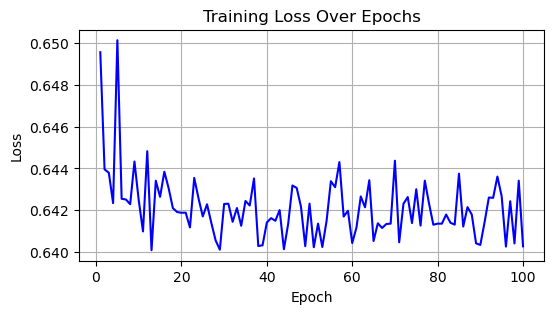

In [79]:
# visualize loss values
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# F1 Scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), gnn_scores, marker='o', linestyle='-', color='darkgreen')
plt.title("GNN F1 Scores Across Folds (ADHD Prediction)", fontsize=16)
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0.75, 0.95)
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_vals, y_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title(f"Confusion Matrix – {name}", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

labels = class_labels[name]
plt.xticks([0.5, 1.5], labels) 
plt.yticks([0.5, 1.5], labels) 

plt.tight_layout()
plt.show()

In [84]:
# TESTING!!! NEED TO FINISH

test_loader = DataLoader(X_test, batch_size=8, shuffle=False)
y_true, y_pred, y_probs = evaluate_model(model, test_loader)

# for each target variable
target_names = ['ADHD_Outcome', 'Sex_F']
class_labels = {
    "ADHD_Outcome": ["No ADHD", "ADHD"],
    "Sex_F": ["Male", "Female"]
}
